# Air Quality Challenge

### Importing dependencies

In [0]:
import math
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as sp
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing  import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

### Importing dataset and premilinary data visualization

In [0]:
dataset = pd.read_csv('qualidade_do_ar.csv',sep=';',parse_dates= {'DateTime' : [0, 1]})
dataset.head()

,DateTime,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004 18.00.00,1360,150,"11,9",1046,166,1056,113,1692,1268,"13,6","48,9","0,7578"
1,10/03/2004 19.00.00,1292,112,"9,4",955,103,1174,92,1559,972,"13,3","47,7","0,7255"
2,10/03/2004 20.00.00,1402,88,9,939,131,1140,114,1555,1074,"11,9",54,"0,7502"
3,10/03/2004 21.00.00,1376,80,"9,2",948,172,1092,122,1584,1203,11,60,"0,7867"
4,10/03/2004 22.00.00,1272,51,"6,5",836,131,1205,116,1490,1110,"11,2","59,6","0,7888"


### Preprocessing

Formatting date and time:

In [0]:
date_time_str = dataset['DateTime'];
dataset['DateTime'] = [datetime.strptime(date, '%d/%m/%Y %H.%M.%S') for date in dataset['DateTime']]

Formatting features to numeric values:

In [0]:
print(dataset.dtypes)

DateTime         datetime64[ns]
PT08.S1(CO)               int64
NMHC(GT)                  int64
C6H6(GT)                 object
PT08.S2(NMHC)             int64
NOx(GT)                   int64
PT08.S3(NOx)              int64
NO2(GT)                   int64
PT08.S4(NO2)              int64
PT08.S5(O3)               int64
T                        object
RH                       object
AH                       object
dtype: object


In [0]:
def replaceStringForNumeric(dataFrame,columns):
    for column in columns:
        dataFrame[column] = dataFrame[column].astype('str').replace({',': '.'},regex=True).astype('float')
    return dataFrame


In [0]:
dataset_numeric = replaceStringForNumeric(dataset,['C6H6(GT)','T','RH','AH']);

In [0]:
dataset_numeric.describe()

,PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


#### Treating missing data

Replacing data points equal to -200 for NaN and visualizing number of valid data points

In [0]:
dataset_numeric = dataset_numeric.replace(to_replace=-200,value=np.nan)
values_not_NaN = dataset_numeric.count()
print(values_not_NaN)

DateTime         9357
PT08.S1(CO)      8991
NMHC(GT)          914
C6H6(GT)         8991
PT08.S2(NMHC)    8991
NOx(GT)          7718
PT08.S3(NOx)     8991
NO2(GT)          7715
PT08.S4(NO2)     8991
PT08.S5(O3)      8991
T                8991
RH               8991
AH               8991
dtype: int64


Since there is roughly 10% of valid numeric data for the feature NMHC(GT), it will be removed from dataset.

In [0]:
dataset_numeric = dataset_numeric.drop(axis=1,labels='NMHC(GT)')

Supposing that data would not change dastrically in two hours, we will interpolate data points up to two missing data points consecutively. If there is more than two missing data points, they will be removed.

In [0]:
dataset_interpolate = dataset_numeric.interpolate(limit=2)
dataset_interpolate = dataset_interpolate.dropna()
dataset_interpolate.describe()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7772.000000,7772.00000,7772.000000,7772.00000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000,7772.000000
mean,1104.421713,10.12237,940.455524,237.09544,834.441531,110.452633,1444.831206,1034.662139,17.874922,49.078370,0.996435
std,219.054535,7.43947,267.409092,205.44542,262.290358,47.952778,352.248770,406.115976,8.979548,17.462284,0.404500
min,647.000000,0.10000,383.000000,2.00000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700
25%,939.000000,4.40000,734.000000,93.00000,654.000000,74.000000,1202.000000,737.000000,11.200000,35.600000,0.699925
50%,1069.000000,8.30000,913.000000,173.00000,799.000000,107.000000,1450.000000,977.000000,17.000000,49.400000,0.967400
75%,1238.000000,14.10000,1121.000000,315.00000,969.000000,139.000000,1675.000000,1294.250000,23.925000,62.500000,1.275700
max,2040.000000,63.70000,2214.000000,1479.00000,2683.000000,333.000000,2775.000000,2523.000000,44.600000,88.700000,2.180600


In [0]:
def calculateDatasetPercentage(dataset,max_size):
    percentage = 100* dataset.count()[0] / max_size
    print('Percentage of remaining data: %2.2f' %percentage )    


In [0]:
calculateDatasetPercentage(dataset = dataset_interpolate, max_size=9357)

Percentage of remaining data: 83.06


#### Treating Outliers

Each featurein the dataset will be treated separately, so we will use the Z-Score metric to identify and remove outliers.
A threshold of 3 standard deviations will be considered to indetify the outliers.

In [0]:
z_score = np.abs(sp.zscore(dataset_interpolate.drop(axis=1,labels=['DateTime'])))
threshold = 3
dataset_no_outliers = dataset_interpolate[(z_score < 3).all(axis=1)]
dataset_no_outliers.describe()

,PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,7417.000000,7417.000000,7417.000000,7417.000000,7417.000000,7417.000000,7417.000000,7417.000000,7417.000000,7417.000000,7417.000000
mean,1091.992232,9.585666,926.390435,219.766156,832.519007,108.322302,1434.562552,1012.255867,18.113621,48.729381,1.002529
std,198.640064,6.428231,243.131401,171.876646,229.470343,44.535232,335.489917,369.947414,9.013749,17.492623,0.405248
min,667.000000,0.300000,412.000000,2.000000,345.000000,2.000000,601.000000,261.000000,-1.900000,9.200000,0.184700
25%,939.000000,4.400000,734.000000,92.000000,667.000000,74.000000,1202.000000,737.000000,11.500000,35.000000,0.708100
50%,1064.000000,8.200000,906.000000,168.000000,804.000000,105.000000,1444.000000,968.000000,17.400000,48.900000,0.972500
75%,1218.000000,13.500000,1102.000000,297.000000,967.000000,136.000000,1663.000000,1259.000000,24.300000,62.200000,1.283900
max,1751.000000,32.300000,1603.000000,852.000000,1620.000000,254.000000,2486.000000,2236.000000,44.600000,88.700000,2.180600


In [0]:
calculateDatasetPercentage(dataset = dataset_no_outliers, max_size=9357)

Percentage of remaining data: 79.27


After treating missing data and outliers, we still have more than 79% of the features in the original dataset.

 Let us visualize the PT08.S1(CO) feature after pre-processing.

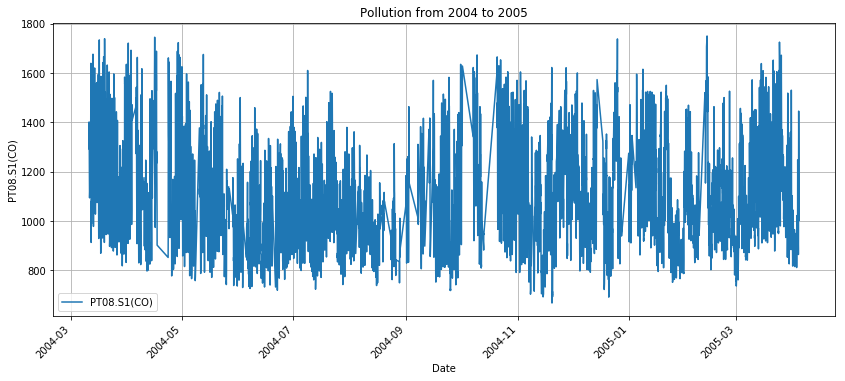

In [0]:
visualization = pd.DataFrame(data=dataset_no_outliers['PT08.S1(CO)']).set_index(dataset_no_outliers['DateTime'])
visualization.plot(figsize=(14,6), fontsize=10,grid=True)
plt.xticks(rotation=45);
plt.title('Pollution from 2004 to 2005')
plt.ylabel("PT08.S1(CO)")
plt.xlabel("Date");
plt.show()

### Data Visualization during Peak Hour

Calculating hourly average values of pollution for each day of the week

In [0]:
def getMeanValuesByDayOfTheWeek(dataset,column):
    hours_of_the_day = [x for x in range(24)]
    days_of_the_week = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
    mean_values = pd.DataFrame(index=hours_of_the_day,columns=days_of_the_week)
    for index,day in enumerate(days_of_the_week, start=0):
        daily_dataset = dataset[[x.weekday() == index for x in dataset['DateTime']]]
        for hour in hours_of_the_day:
            hour_mean = daily_dataset[[x.hour == hour for x in daily_dataset['DateTime']]][column].mean()
            mean_values[day][hour] = hour_mean
    return mean_values

In [0]:
mean_values_for_pollution = getMeanValuesByDayOfTheWeek(dataset = dataset_no_outliers[['DateTime','PT08.S1(CO)']],column = 'PT08.S1(CO)')
mean_values_for_pollution

,monday,tuesday,wednesday,thursday,friday,saturday,sunday
0,1003.22,980.375,1046.17,1077.63,1100.25,1127.1,1145.09
1,948.318,926.021,993.833,1013.61,1040.53,1075.53,1073.63
2,916,875.5,944.095,940.174,962.422,1015.18,1004.76
3,876.85,855.25,899.775,897.744,919.023,976.94,969.696
4,864.974,849.357,882.725,880.881,912.837,941.588,925.8
5,882.513,877.023,900.333,898.907,920.114,930.51,885.477
6,942.273,973.867,977.634,962.269,987.886,958.286,888.727
7,1086.85,1173.09,1180.4,1162.34,1198.76,1024.45,910.978
8,1210.18,1290.03,1292.71,1316.97,1355.27,1117.6,943.622
9,1171.95,1268.3,1282.5,1286.7,1301.16,1159.94,979.467


Lets consider the three highest values to determine peak hours.

In [0]:
For Wednesdays we have the following:

SyntaxError: invalid syntax (<ipython-input-1106-b96bdfad2c6e>, line 1)

In [0]:
mean_values_for_pollution['wednesday'].astype('float').nlargest(3)

It is noticeable that the there is a peak moment during the morning, between 8:00 and 9:00. Now, let us expand the search for five highest values.

In [0]:
mean_values_for_pollution['wednesday'].astype('float').nlargest(5)

Therefore, we can also notice that there is a peak moment during the evening, between 18:00 and 20:00, with 19:00 having the highest value in this interval.

### Data Correlation and Feature Selection

#### Linear Correlation

Let us analyse the variable correlation with two linear correlation metrics: 
  - Spearman Correlation;
  - Pearson Correlation.

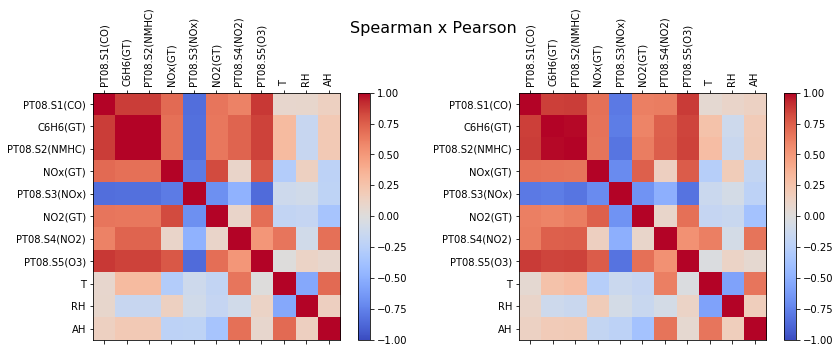

In [0]:
data = dataset_no_outliers.drop(axis=1,labels=['DateTime'])
correlation_spearman = data.corr(method='spearman')

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(221)
cax = ax.matshow(correlation_spearman,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
# ax.set_title('subplot 2')

correlation_pearson = data.corr(method='pearson')
ax = fig.add_subplot(222)
cax = ax.matshow(correlation_pearson,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)

fig.suptitle('Spearman x Pearson', fontsize=16)
plt.show()

Values close to 0 show low linear correlation between the target and the features. It will be considered values of 0.5 and -0.5 to select the most correlated features.

In [0]:
correlation_spearman['PT08.S1(CO)'][correlation_spearman['PT08.S1(CO)'] > 0.5][1:]

C6H6(GT)         0.873891
PT08.S2(NMHC)    0.873913
NOx(GT)          0.706328
NO2(GT)          0.660647
PT08.S4(NO2)     0.602830
PT08.S5(O3)      0.884720
Name: PT08.S1(CO), dtype: float64

In [0]:
correlation_spearman['PT08.S1(CO)'][correlation_spearman['PT08.S1(CO)'] < -0.5 ]

PT08.S3(NOx)   -0.843474
Name: PT08.S1(CO), dtype: float64

In [0]:
correlation_pearson['PT08.S1(CO)'][correlation_spearman['PT08.S1(CO)'] > 0.5][1:]

C6H6(GT)         0.864293
PT08.S2(NMHC)    0.870192
NOx(GT)          0.682685
NO2(GT)          0.622020
PT08.S4(NO2)     0.630149
PT08.S5(O3)      0.881387
Name: PT08.S1(CO), dtype: float64

In [0]:
correlation_spearman['PT08.S1(CO)'][correlation_spearman['PT08.S1(CO)'] < -0.5 ]

PT08.S3(NOx)   -0.843474
Name: PT08.S1(CO), dtype: float64

For both metrics, the variables C6H6(GT), PT08.S2(NMHC), NOx(GT), NO2(GT),PT08.S4(NO2) and PT08.S5(O3) are strongly and directly correlated with PT08.S1(CO), whereas PT08.S3(NOx) is inversely correlated with PT08.S1(CO)

#### Non Linear Correlation

RFE method with a LinearRegression model will be applied to find non linear correlations for PT08.S1(CO).

In [0]:
X = dataset_no_outliers.drop(axis=1,labels=['DateTime','PT08.S1(CO)'])
y = dataset_no_outliers['PT08.S1(CO)']

nof_list=np.arange(1,10)            
high_score=0
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0,shuffle=False)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
cols = list(X.columns)
model = LinearRegression()
rfe = RFE(model, nof)             
X_rfe = rfe.fit_transform(X,y)  
model.fit(X_rfe,y)           

temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print("Score with %d features: %f" % (nof, high_score))
print(selected_features_rfe)


Score with 6 features: 0.790851
Index(['C6H6(GT)', 'NO2(GT)', 'PT08.S5(O3)', 'T', 'RH', 'AH'], dtype='object')


### Data Prediction

The following methods will be used to evaluate how different aproaches perform in this regression problem:
 - Linear Regression Model
 - Multi Layer Perceptron
 - Extreme Gradient Boosting 
 - Random Forest

Each model will be executed with the dataset suggested by the Pearson/Spearman linear correlations and also the RFE method.  

#### Dataset composed by the variables selected on Pearson/Spearman Correlations

Separating data in Train and Test sets

In [0]:
X = dataset_no_outliers[['C6H6(GT)','PT08.S2(NMHC)','NOx(GT)', 'NO2(GT)','PT08.S4(NO2)', 'PT08.S5(O3)', 'PT08.S3(NOx)']]
y = dataset_no_outliers[['PT08.S1(CO)']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,shuffle=False)

In [0]:
def normalizeDataSet(dataset):
    
    scaler = MinMaxScaler()
    columns = [i for i in dataset]
    normalized = scaler.fit_transform(pd.DataFrame(dataset))
    normalized  = pd.DataFrame(normalized, index=dataset.index,columns=columns)
    return normalized,scaler

In [0]:
def compareRealWithPredicted(real,predicted,dates):
    df_real = pd.DataFrame(data=real,columns=['Real'])
    df_predicted = pd.DataFrame(data=predicted,columns=['Predicted'])
    df_complete = pd.concat([df_real,df_predicted],axis=1).set_index(dates)
    df_complete.plot(figsize=(14,6), fontsize=10,grid=True)
    plt.xticks(rotation=45);
    plt.title('Pollution (PT08.S1(CO)) from 2004 to 2005')
    plt.ylabel("PT08.S1(CO)")
    plt.xlabel("Date");
    plt.show()
    return df_complete

In [0]:
result_metrics = pd.DataFrame(
    columns=['Linear Regression','Random Forest','XGBoost','MLP'],
    index=['R2 Score - Linear Corr','R2 Score - RFE','RMSE - Linear Corr','RMSE - RFE'])

Normalizing sets

In [0]:
X_train_norm,scaler_X_train = normalizeDataSet(X_train)
X_test_norm,scaler_X_test = normalizeDataSet(X_test)
y_train_norm,scaler_y_train = normalizeDataSet(y_train)
y_test_norm,scaler_y_test = normalizeDataSet(y_test)

#### Linear Regression Model:

In [0]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_norm,y_train_norm)
score = linear_regression_model.score(X_test_norm,y_test_norm)

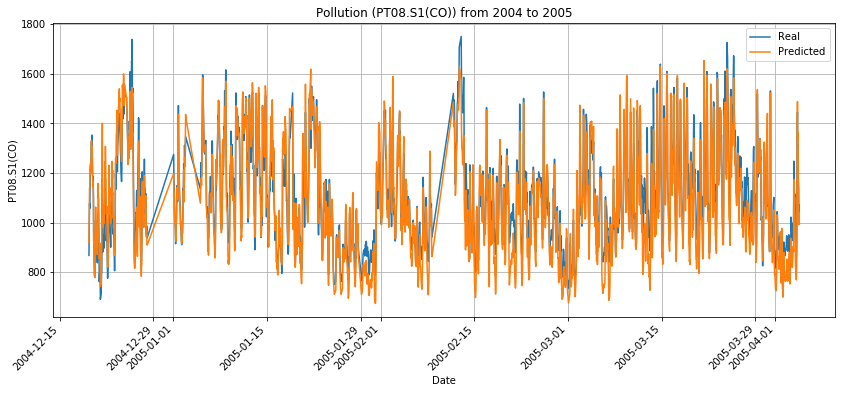

,Real,Predicted
count,2226.000000,2226.000000
mean,1099.575767,1068.479629
std,195.360458,214.696013
min,691.000000,674.273950
25%,946.250000,900.308764
50%,1067.500000,1039.168043
75%,1220.750000,1212.965897
max,1751.000000,1652.758933


In [0]:
predicted_data_norm = linear_regression_model.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(predicted_data_norm)
dates = dataset_no_outliers['DateTime'][-predicted_data.size:];
linear_regression_prediction = compareRealWithPredicted(y_test.values,predicted_data,dates)
linear_regression_prediction.describe()

In [0]:
rmse = (mean_squared_error(linear_regression_prediction['Real'],linear_regression_prediction['Predicted']))**0.5
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%score)
result_metrics['Linear Regression']['R2 Score - Linear Corr'] = score
result_metrics['Linear Regression']['RMSE - Linear Corr'] = rmse

RMSE: 72.42
R2: 0.86


#### Random Forest

In [0]:
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train_norm, y_train_norm.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

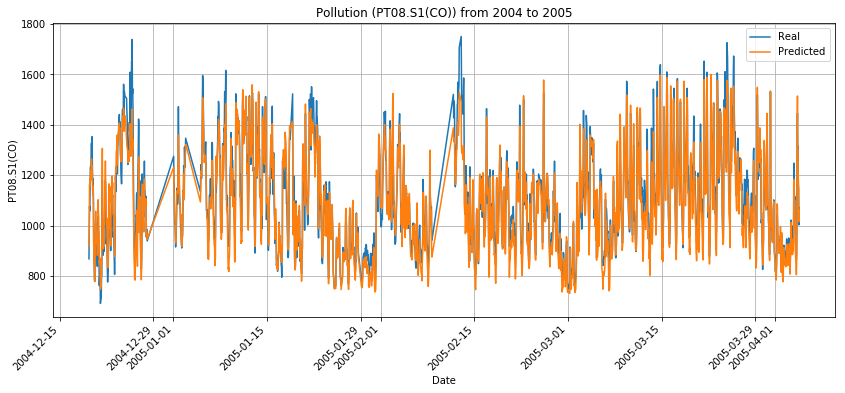

,Real,Predicted
count,2226.000000,2226.000000
mean,1099.575767,1078.247176
std,195.360458,191.714477
min,691.000000,731.028508
25%,946.250000,919.743383
50%,1067.500000,1065.965022
75%,1220.750000,1212.840014
max,1751.000000,1600.186265


In [0]:
prediction_norm = rf.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(prediction_norm.reshape(-1, 1))
dates = dataset_no_outliers['DateTime'][-predicted_data.size:];
random_forest_prediction = compareRealWithPredicted(y_test.values,predicted_data,dates)
random_forest_prediction.describe()

In [0]:
rmse = (mean_squared_error(random_forest_prediction['Real'],random_forest_prediction['Predicted']))**0.5
r2score = r2_score(random_forest_prediction['Real'],random_forest_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics['Random Forest']['R2 Score - Linear Corr'] = r2score
result_metrics['Random Forest']['RMSE - Linear Corr'] = rmse

RMSE: 56.45
R2: 0.92


#### XGBoost

In [0]:
dtrain = xgb.DMatrix(X_train_norm, y_train_norm)
dtest = xgb.DMatrix(X_test_norm, y_test_norm)
# specify parameters via map, definition are same as c++ version
params = {
    'max_depth':3, 
    'eta':1, 
    'silent':1,
    'objective':'reg:linear',
    'subsample': 0.8,   
    'num_parallel_tree': 10,
    'learning_rate':0.05}

# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 70
bst = xgb.train(params, dtrain, num_round, watchlist, evals_result=evals_result);

[0]	eval-rmse:0.207249	train-rmse:0.205993
[1]	eval-rmse:0.198035	train-rmse:0.197444
[2]	eval-rmse:0.189348	train-rmse:0.189391
[3]	eval-rmse:0.181115	train-rmse:0.181779
[4]	eval-rmse:0.173396	train-rmse:0.174615
[5]	eval-rmse:0.166117	train-rmse:0.167873
[6]	eval-rmse:0.159237	train-rmse:0.161503
[7]	eval-rmse:0.152534	train-rmse:0.155493
[8]	eval-rmse:0.146236	train-rmse:0.149849
[9]	eval-rmse:0.140493	train-rmse:0.144544
[10]	eval-rmse:0.135024	train-rmse:0.139559
[11]	eval-rmse:0.129931	train-rmse:0.134888
[12]	eval-rmse:0.125171	train-rmse:0.130483
[13]	eval-rmse:0.120476	train-rmse:0.126354
[14]	eval-rmse:0.116019	train-rmse:0.122503
[15]	eval-rmse:0.111707	train-rmse:0.118887
[16]	eval-rmse:0.107741	train-rmse:0.115491
[17]	eval-rmse:0.104048	train-rmse:0.112322
[18]	eval-rmse:0.100598	train-rmse:0.109354
[19]	eval-rmse:0.097207	train-rmse:0.106592
[20]	eval-rmse:0.094214	train-rmse:0.103999
[21]	eval-rmse:0.090965	train-rmse:0.101578
[22]	eval-rmse:0.088147	train-rmse:0.09930

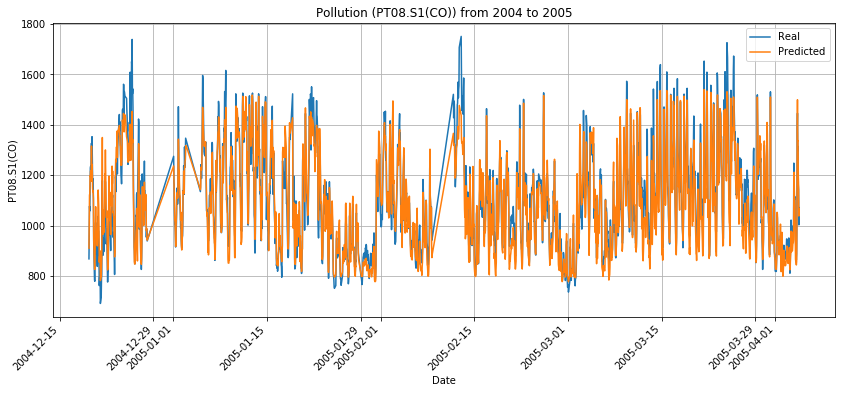

,Real,Predicted
count,2226.000000,2226.000000
mean,1099.575767,1083.455098
std,195.360458,188.017805
min,691.000000,777.393081
25%,946.250000,922.561133
50%,1067.500000,1067.355335
75%,1220.750000,1219.060851
max,1751.000000,1539.721792


In [0]:
predicted_norm = bst.predict(dtest)
predicted = scaler_y_test.inverse_transform(pd.DataFrame(predicted_norm))
dates = dataset_no_outliers['DateTime'][-predicted.size:];
xgboost_prediction = compareRealWithPredicted(y_test.values,predicted,dates)
xgboost_prediction.describe()

In [0]:
rmse = (mean_squared_error(xgboost_prediction['Real'],xgboost_prediction['Predicted']))**0.5
r2score = r2_score(xgboost_prediction['Real'],xgboost_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics['XGBoost']['R2 Score - Linear Corr'] = r2score
result_metrics['XGBoost']['RMSE - Linear Corr'] = rmse

RMSE: 59.48
R2: 0.91


#### Multi Layer Perceptron Neural Network

In [0]:
mlp = MLPRegressor(hidden_layer_sizes=(X.columns.size,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01,
                                       validation_fraction=0.2 )
model = mlp.fit(X_train_norm, y_train_norm.values.ravel())

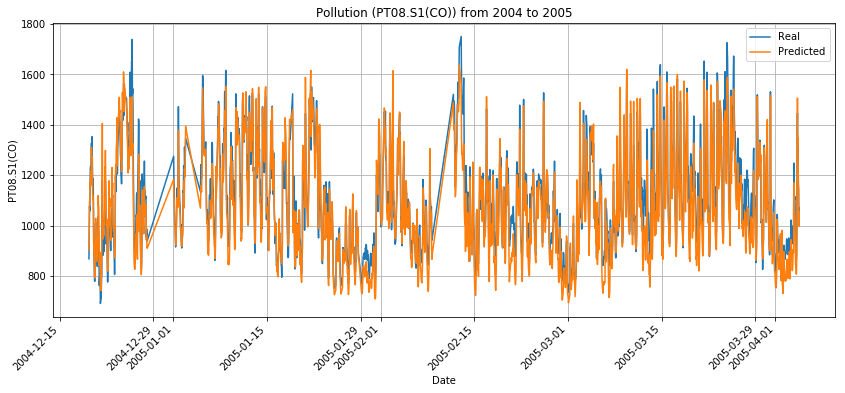

,Real,Predicted
count,2226.000000,2226.000000
mean,1099.575767,1065.094308
std,195.360458,203.867142
min,691.000000,693.294170
25%,946.250000,907.092709
50%,1067.500000,1030.989484
75%,1220.750000,1194.691955
max,1751.000000,1637.896212


In [0]:
prediction_norm = model.predict(X_test_norm)
prediction = scaler_y_test.inverse_transform(pd.DataFrame(prediction_norm))
dates = dataset_no_outliers['DateTime'][-prediction.size:];
mlp_prediction = compareRealWithPredicted(y_test.values,prediction,dates)
mlp_prediction.describe()

In [0]:
rmse = (mean_squared_error(mlp_prediction['Real'],mlp_prediction['Predicted']))**0.5
r2score = r2_score(mlp_prediction['Real'],mlp_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics['MLP']['R2 Score - Linear Corr'] = r2score
result_metrics['MLP']['RMSE - Linear Corr'] = rmse

RMSE: 68.55
R2: 0.88


#### Dataset composed by the variables selected by the RFE method

Separating data in Train and Test sets

In [0]:
X = dataset_no_outliers[['C6H6(GT)', 'NO2(GT)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
y = dataset_no_outliers[['PT08.S1(CO)']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,shuffle=False)

Normalizing sets

In [0]:
X_train_norm,scaler_X_train = normalizeDataSet(X_train)
X_test_norm,scaler_X_test = normalizeDataSet(X_test)
y_train_norm,scaler_y_train = normalizeDataSet(y_train)
y_test_norm,scaler_y_test = normalizeDataSet(y_test)

#### Linear Regression Model:

In [0]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_norm,y_train_norm)
score = linear_regression_model.score(X_test_norm,y_test_norm)

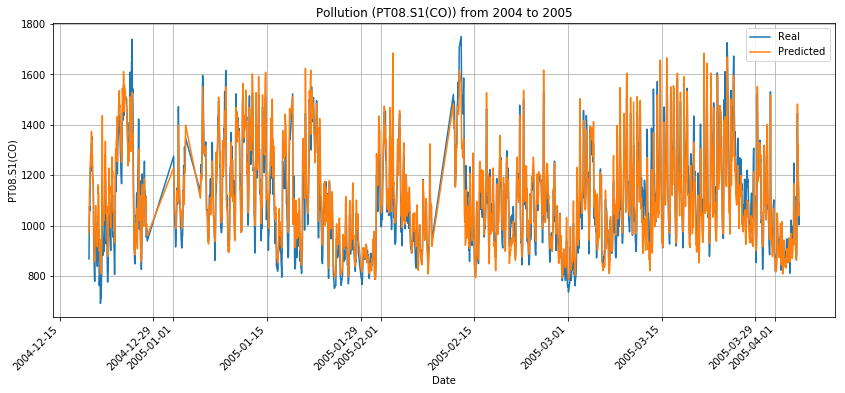

,Real,Predicted
count,2226.000000,2226.000000
mean,1099.575767,1104.075378
std,195.360458,186.678906
min,691.000000,786.342601
25%,946.250000,959.707118
50%,1067.500000,1068.507024
75%,1220.750000,1218.451656
max,1751.000000,1684.565014


In [0]:
predicted_data_norm = linear_regression_model.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(predicted_data_norm)
dates = dataset_no_outliers['DateTime'][-predicted_data.size:];
linear_regression_prediction = compareRealWithPredicted(y_test.values,predicted_data,dates)
linear_regression_prediction.describe()

In [0]:
rmse = (mean_squared_error(linear_regression_prediction['Real'],linear_regression_prediction['Predicted']))**0.5
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%score)
result_metrics['Linear Regression']['R2 Score - RFE'] = score
result_metrics['Linear Regression']['RMSE - RFE'] = rmse

RMSE: 63.71
R2: 0.89


#### Random Forest

In [0]:
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train_norm, y_train_norm.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

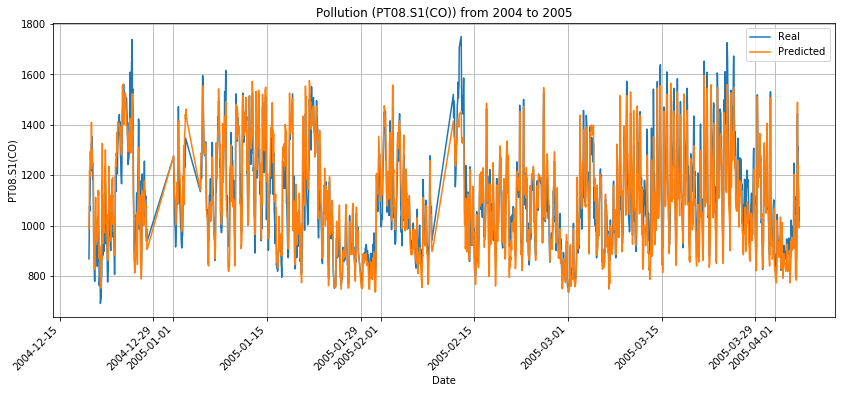

,Real,Predicted
count,2226.000000,2226.000000
mean,1099.575767,1089.458869
std,195.360458,197.679804
min,691.000000,736.254829
25%,946.250000,922.358835
50%,1067.500000,1073.434345
75%,1220.750000,1227.704819
max,1751.000000,1595.536608


In [0]:
prediction_norm = rf.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(prediction_norm.reshape(-1, 1))
dates = dataset_no_outliers['DateTime'][-predicted_data.size:];
random_forest_prediction = compareRealWithPredicted(y_test.values,predicted_data,dates)
random_forest_prediction.describe()

In [0]:
rmse = (mean_squared_error(random_forest_prediction['Real'],random_forest_prediction['Predicted']))**0.5
r2score = r2_score(random_forest_prediction['Real'],random_forest_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics['Random Forest']['R2 Score - RFE'] = r2score
result_metrics['Random Forest']['RMSE - RFE'] = rmse

RMSE: 74.68
R2: 0.85


#### XGBoost

In [0]:
dtrain = xgb.DMatrix(X_train_norm, y_train_norm)
dtest = xgb.DMatrix(X_test_norm, y_test_norm)
# specify parameters via map, definition are same as c++ version
params = {
    'max_depth':3, 
    'eta':1, 
    'silent':1,
    'objective':'reg:linear',
    'subsample': 0.8,   
    'num_parallel_tree': 10,
    'learning_rate':0.05}

# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 60
bst = xgb.train(params, dtrain, num_round, watchlist, evals_result=evals_result);

[0]	eval-rmse:0.207149	train-rmse:0.206007
[1]	eval-rmse:0.197886	train-rmse:0.197469
[2]	eval-rmse:0.189027	train-rmse:0.18942
[3]	eval-rmse:0.180643	train-rmse:0.181826
[4]	eval-rmse:0.172876	train-rmse:0.174678
[5]	eval-rmse:0.165527	train-rmse:0.16795
[6]	eval-rmse:0.158837	train-rmse:0.161609
[7]	eval-rmse:0.152226	train-rmse:0.155624
[8]	eval-rmse:0.145958	train-rmse:0.150002
[9]	eval-rmse:0.14022	train-rmse:0.144723
[10]	eval-rmse:0.134727	train-rmse:0.139754
[11]	eval-rmse:0.129607	train-rmse:0.135102
[12]	eval-rmse:0.124813	train-rmse:0.130714
[13]	eval-rmse:0.120285	train-rmse:0.126596
[14]	eval-rmse:0.116011	train-rmse:0.122759
[15]	eval-rmse:0.112026	train-rmse:0.11915
[16]	eval-rmse:0.108368	train-rmse:0.115768
[17]	eval-rmse:0.104953	train-rmse:0.112605
[18]	eval-rmse:0.101722	train-rmse:0.109645
[19]	eval-rmse:0.098681	train-rmse:0.106879
[20]	eval-rmse:0.095895	train-rmse:0.104287
[21]	eval-rmse:0.093326	train-rmse:0.101869
[22]	eval-rmse:0.090963	train-rmse:0.0996
[23]

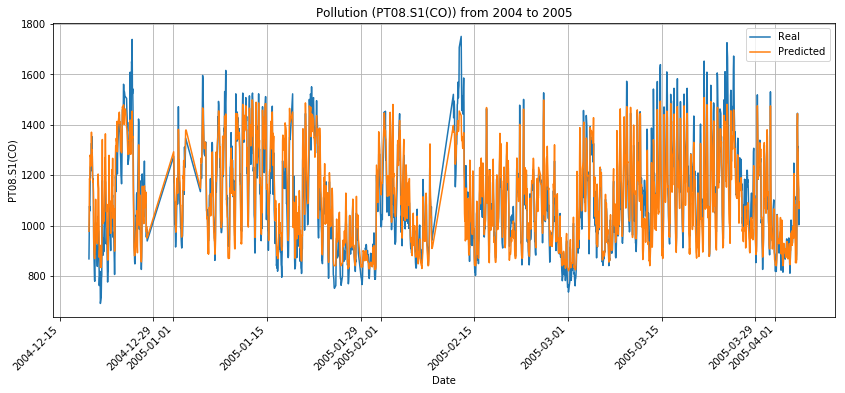

,Real,Predicted
count,2226.000000,2226.000000
mean,1099.575767,1103.639452
std,195.360458,180.342404
min,691.000000,820.651828
25%,946.250000,949.468751
50%,1067.500000,1080.629584
75%,1220.750000,1241.241051
max,1751.000000,1508.159698


In [0]:
predicted_norm = bst.predict(dtest)
predicted = scaler_y_test.inverse_transform(pd.DataFrame(predicted_norm))
dates = dataset_no_outliers['DateTime'][-predicted.size:];
xgboost_prediction = compareRealWithPredicted(y_test.values,predicted,dates)
xgboost_prediction.describe()

In [0]:
rmse = (mean_squared_error(xgboost_prediction['Real'],xgboost_prediction['Predicted']))**0.5
r2score = r2_score(xgboost_prediction['Real'],xgboost_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics['XGBoost']['R2 Score - RFE'] = r2score
result_metrics['XGBoost']['RMSE - RFE'] = rmse

RMSE: 68.08
R2: 0.88


#### Multi Layer Perceptron Neural Network

In [0]:
mlp = MLPRegressor(hidden_layer_sizes=(X.columns.size,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01,
                                       validation_fraction=0.2 )
model = mlp.fit(X_train_norm, y_train_norm.values.ravel())

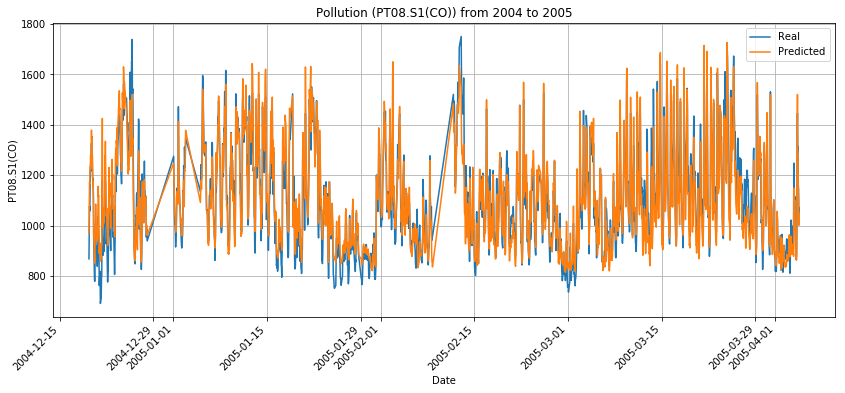

,Real,Predicted
count,2226.000000,2226.000000
mean,1099.575767,1097.254034
std,195.360458,187.471242
min,691.000000,814.596782
25%,946.250000,950.122153
50%,1067.500000,1061.389800
75%,1220.750000,1211.398950
max,1751.000000,1726.429173


In [0]:
prediction_norm = model.predict(X_test_norm)
prediction = scaler_y_test.inverse_transform(pd.DataFrame(prediction_norm))
dates = dataset_no_outliers['DateTime'][-prediction.size:];
mlp_prediction = compareRealWithPredicted(y_test.values,prediction,dates)
mlp_prediction.describe()

In [0]:
rmse = (mean_squared_error(mlp_prediction['Real'],mlp_prediction['Predicted']))**0.5
r2score = r2_score(mlp_prediction['Real'],mlp_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics['MLP']['R2 Score - RFE'] = r2score
result_metrics['MLP']['RMSE - RFE'] = rmse

RMSE: 63.96
R2: 0.89


In [0]:
result_metrics

,Linear Regression,Random Forest,XGBoost,MLP
R2 Score - Linear Corr,0.862507,0.916481,0.907271,0.876806
R2 Score - RFE,0.893592,0.853787,0.878517,0.892769
RMSE - Linear Corr,72.4235,56.446,59.4766,68.5542
RMSE - RFE,63.7128,74.6847,68.0765,63.9586


### Treating Seasonality in Data

Let us remove the seasonality from the dataset by differentiating the data points.

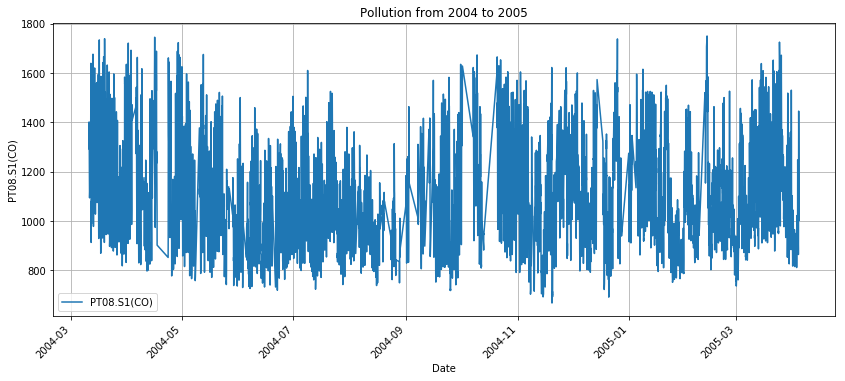

In [0]:
visualization = pd.DataFrame(data=dataset_no_outliers['PT08.S1(CO)']).set_index(dataset_no_outliers['DateTime'])
visualization.plot(figsize=(14,6), fontsize=10,grid=True)
plt.xticks(rotation=45);
plt.title('Pollution from 2004 to 2005')
plt.ylabel("PT08.S1(CO)")
plt.xlabel("Date");
plt.show()

In [0]:
def diffData(dataset):
    diff = list()
    for i in range(interval, dataset.size):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return diff

def undoDiffData(original, diff):
    data_diff = diff
    data_original = original.values.flatten()
    inverted = [(data_original[i] + data_diff[i]) for i in range(len(data_diff))]
    return inverted

In [0]:
dataset_no_season = pd.DataFrame(columns=dataset_interpolate.columns.values)[1:];
columns_no_Datetime = dataset_interpolate.drop(axis=1,labels=['DateTime']).columns.values

for column in columns_no_Datetime:
    dataset_no_season[column] = diffData(dataset_interpolate[column].values)
dataset_no_season['DateTime'] = dataset_interpolate['DateTime'][1:].values

Visualizing PT08.S1(CO) after differentiation

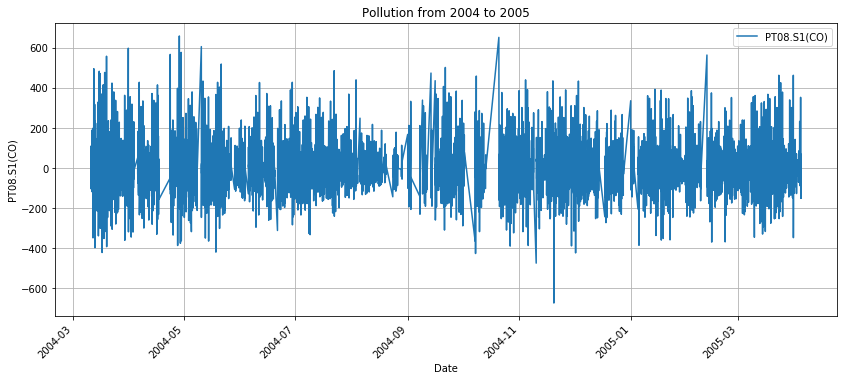

In [0]:
visualization = pd.DataFrame(data=dataset_no_season['PT08.S1(CO)']).set_index(dataset_no_season['DateTime'])
visualization.plot(figsize=(14,6), fontsize=10,grid=True)
plt.xticks(rotation=45);
plt.title('Pollution from 2004 to 2005')
plt.ylabel("PT08.S1(CO)")
plt.xlabel("Date");
plt.show()

#### Data Prediction without Seansonality

The same steps of the previous Data Prediction Section will be followed

#### Dataset composed by the variables selected on Pearson/Spearman Correlations

Separating data in Train and Test sets

In [0]:
X = dataset_no_season[['C6H6(GT)','PT08.S2(NMHC)','NOx(GT)', 'NO2(GT)','PT08.S4(NO2)', 'PT08.S5(O3)', 'PT08.S3(NOx)']]
y = dataset_no_season[['PT08.S1(CO)']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,shuffle=False)

In [0]:
result_metrics_no_seasonality = pd.DataFrame(
    columns=['Linear Regression','Random Forest','XGBoost','MLP'],
    index=['R2 Score - Linear Corr','R2 Score - RFE','RMSE - Linear Corr','RMSE - RFE'])

Normalizing sets

In [0]:
X_train_norm,scaler_X_train = normalizeDataSet(X_train)
X_test_norm,scaler_X_test = normalizeDataSet(X_test)
y_train_norm,scaler_y_train = normalizeDataSet(y_train)
y_test_norm,scaler_y_test = normalizeDataSet(y_test)

#### Linear Regression Model:

In [0]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_norm,y_train_norm)
score = linear_regression_model.score(X_test_norm,y_test_norm)

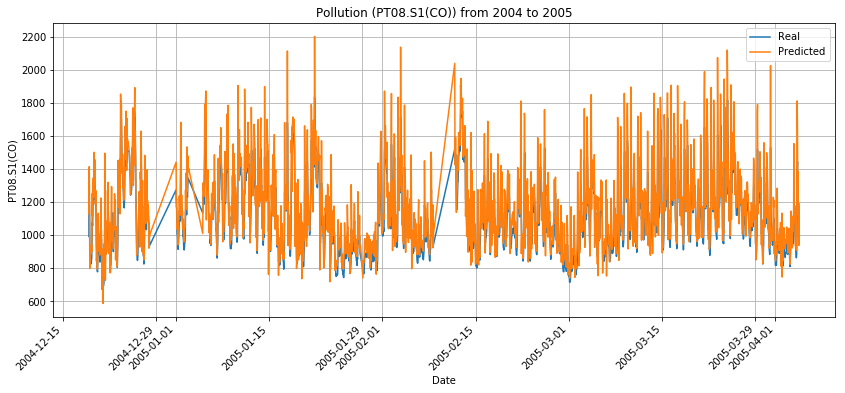

,Real,Predicted
count,2332.000000,2332.000000
mean,1110.438533,1175.864884
std,210.098240,246.218109
min,691.000000,587.513447
25%,947.000000,991.138910
50%,1077.000000,1123.102654
75%,1242.250000,1313.397264
max,1846.000000,2203.294277


In [0]:
predicted_data_norm = linear_regression_model.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(predicted_data_norm)
dates = dataset_no_season['DateTime'][-predicted_data.size:];
predicted_with_season = undoDiffData(dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):],predicted_data.flatten())
original_test_set = dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):].values;
linear_regression_prediction = compareRealWithPredicted(original_test_set,predicted_with_season,dates)
linear_regression_prediction.describe()

In [0]:
rmse = (mean_squared_error(linear_regression_prediction['Real'],linear_regression_prediction['Predicted']))**0.5
r2score = r2_score(linear_regression_prediction['Real'],linear_regression_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics_no_seasonality['Linear Regression']['R2 Score - Linear Corr'] = r2score
result_metrics_no_seasonality['Linear Regression']['RMSE - Linear Corr'] = rmse

RMSE: 111.14
R2: 0.72


#### Random Forest

In [0]:
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train_norm, y_train_norm.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

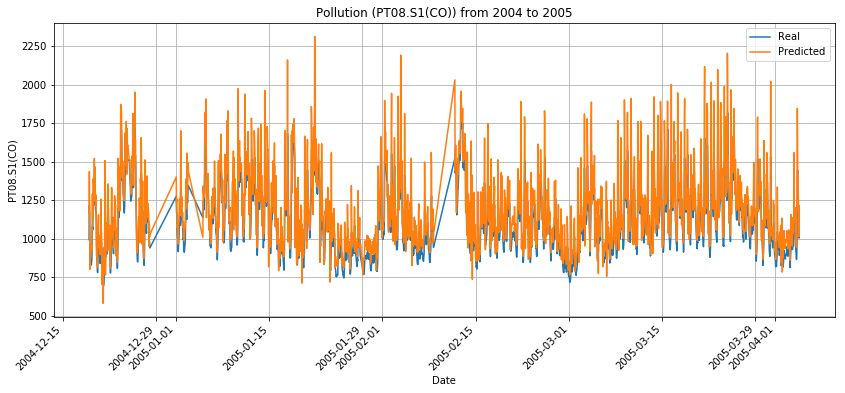

,Real,Predicted
count,2332.000000,2332.000000
mean,1110.438533,1198.716812
std,210.098240,247.241025
min,691.000000,578.292575
25%,947.000000,1015.315526
50%,1077.000000,1144.245377
75%,1242.250000,1333.205938
max,1846.000000,2313.287668


In [0]:
prediction_norm = rf.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(prediction_norm.reshape(-1, 1))
dates = dataset_no_season['DateTime'][-predicted_data.size:];

predicted_with_season = undoDiffData(dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):],predicted_data.flatten())
random_forest_prediction = compareRealWithPredicted(original_test_set,predicted_with_season,dates)
random_forest_prediction.describe()

In [0]:
rmse = (mean_squared_error(random_forest_prediction['Real'],random_forest_prediction['Predicted']))**0.5
r2score = r2_score(random_forest_prediction['Real'],random_forest_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics_no_seasonality['Random Forest']['R2 Score - Linear Corr'] = r2score
result_metrics_no_seasonality['Random Forest']['RMSE - Linear Corr'] = rmse

RMSE: 126.04
R2: 0.64


#### XGBoost

In [0]:
dtrain = xgb.DMatrix(X_train_norm, y_train_norm)
dtest = xgb.DMatrix(X_test_norm, y_test_norm)
# specify parameters via map, definition are same as c++ version
params = {
    'max_depth':3, 
    'eta':1, 
    'silent':1,
    'objective':'reg:linear',
    'subsample': 0.8,   
    'num_parallel_tree': 10,
    'learning_rate':0.05}

# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 500
bst = xgb.train(params, dtrain, num_round, watchlist, evals_result=evals_result);

[0]	eval-rmse:0.134958	train-rmse:0.079018
[1]	eval-rmse:0.132828	train-rmse:0.07567
[2]	eval-rmse:0.130916	train-rmse:0.072506
[3]	eval-rmse:0.129171	train-rmse:0.06951
[4]	eval-rmse:0.127821	train-rmse:0.066683
[5]	eval-rmse:0.126573	train-rmse:0.064008
[6]	eval-rmse:0.125321	train-rmse:0.061477
[7]	eval-rmse:0.123976	train-rmse:0.059081
[8]	eval-rmse:0.1228	train-rmse:0.056808
[9]	eval-rmse:0.121891	train-rmse:0.054664
[10]	eval-rmse:0.120592	train-rmse:0.052631
[11]	eval-rmse:0.119451	train-rmse:0.050719
[12]	eval-rmse:0.118474	train-rmse:0.048916
[13]	eval-rmse:0.117379	train-rmse:0.047207
[14]	eval-rmse:0.116285	train-rmse:0.045593
[15]	eval-rmse:0.115503	train-rmse:0.04407
[16]	eval-rmse:0.114779	train-rmse:0.042643
[17]	eval-rmse:0.114266	train-rmse:0.041298
[18]	eval-rmse:0.113416	train-rmse:0.040029
[19]	eval-rmse:0.112351	train-rmse:0.038831
[20]	eval-rmse:0.111451	train-rmse:0.037701
[21]	eval-rmse:0.110909	train-rmse:0.036645
[22]	eval-rmse:0.110048	train-rmse:0.035653
[23

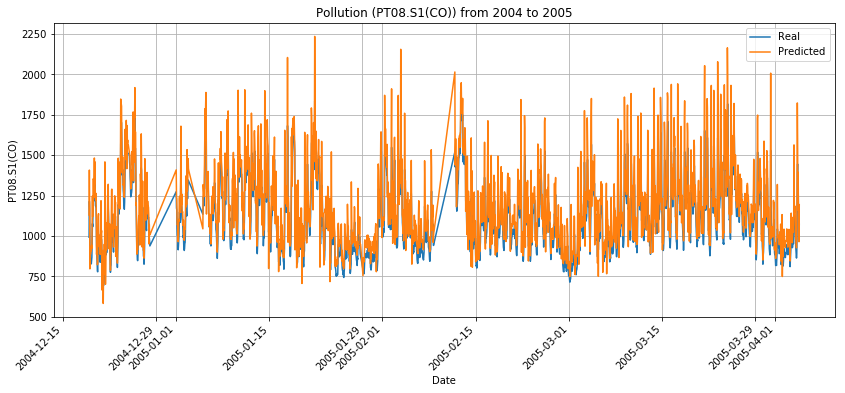

,Real,Predicted
count,2332.000000,2332.000000
mean,1110.438533,1187.575107
std,210.098240,242.748751
min,691.000000,583.184800
25%,947.000000,1004.651382
50%,1077.000000,1136.566491
75%,1242.250000,1322.323472
max,1846.000000,2235.304331


In [0]:
predicted_norm = bst.predict(dtest)
predicted_data = scaler_y_test.inverse_transform(pd.DataFrame(predicted_norm))
dates = dataset_no_season['DateTime'][-predicted_data.size:];

predicted_with_season = undoDiffData(dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):],predicted_data.flatten())
original_test_set = dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):].values;
xgboost_prediction = compareRealWithPredicted(original_test_set,predicted_with_season,dates)
xgboost_prediction.describe()

In [0]:
rmse = (mean_squared_error(xgboost_prediction['Real'],xgboost_prediction['Predicted']))**0.5
r2score = r2_score(xgboost_prediction['Real'],xgboost_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics_no_seasonality['XGBoost']['R2 Score - Linear Corr'] = r2score
result_metrics_no_seasonality['XGBoost']['RMSE - Linear Corr'] = rmse

RMSE: 112.85
R2: 0.71


#### Multi Layer Perceptron Neural Network Regressor

In [0]:
mlp = MLPRegressor(hidden_layer_sizes=(X.columns.size,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01,
                                       validation_fraction=0.2 )
model = mlp.fit(X_train_norm, y_train_norm.values.ravel())

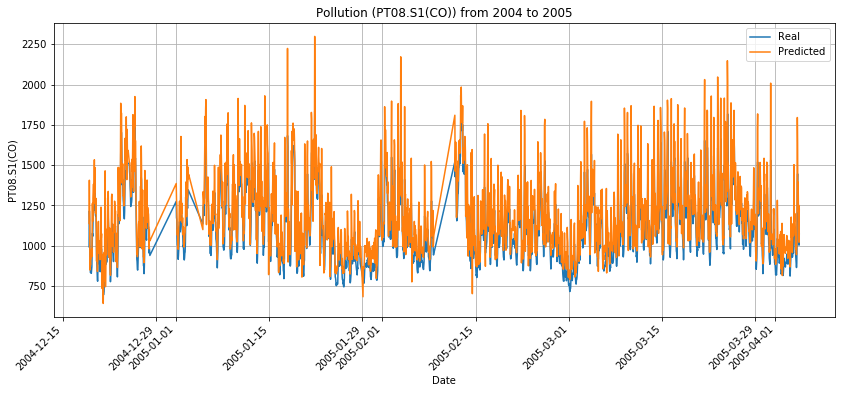

,Real,Predicted
count,2332.000000,2332.000000
mean,1110.438533,1203.167984
std,210.098240,241.655867
min,691.000000,640.994430
25%,947.000000,1023.303897
50%,1077.000000,1150.341982
75%,1242.250000,1334.391842
max,1846.000000,2299.159731


In [0]:
prediction_norm = model.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(pd.DataFrame(prediction_norm))
dates = dataset_no_season['DateTime'][-predicted_data.size:];

predicted_with_season = undoDiffData(dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):],predicted_data.flatten())
original_test_set = dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):].values;

mlp_prediction = compareRealWithPredicted(original_test_set,predicted_with_season,dates)
mlp_prediction.describe()

In [0]:
rmse = (mean_squared_error(mlp_prediction['Real'],mlp_prediction['Predicted']))**0.5
r2score = r2_score(mlp_prediction['Real'],mlp_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics_no_seasonality['MLP']['R2 Score - Linear Corr'] = r2score
result_metrics_no_seasonality['MLP']['RMSE - Linear Corr'] = rmse

RMSE: 124.59
R2: 0.65


#### Dataset composed by the variables selected by the RFE method

Separating data in Train and Test sets

In [0]:
X = dataset_no_season[['C6H6(GT)', 'NO2(GT)', 'PT08.S5(O3)', 'T', 'RH', 'AH']]
y = dataset_no_season[['PT08.S1(CO)']]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,shuffle=False)

Normalizing sets

In [0]:
X_train_norm,scaler_X_train = normalizeDataSet(X_train)
X_test_norm,scaler_X_test = normalizeDataSet(X_test)
y_train_norm,scaler_y_train = normalizeDataSet(y_train)
y_test_norm,scaler_y_test = normalizeDataSet(y_test)

#### Linear Regression Model:

In [0]:
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_norm,y_train_norm)
score = linear_regression_model.score(X_test_norm,y_test_norm)

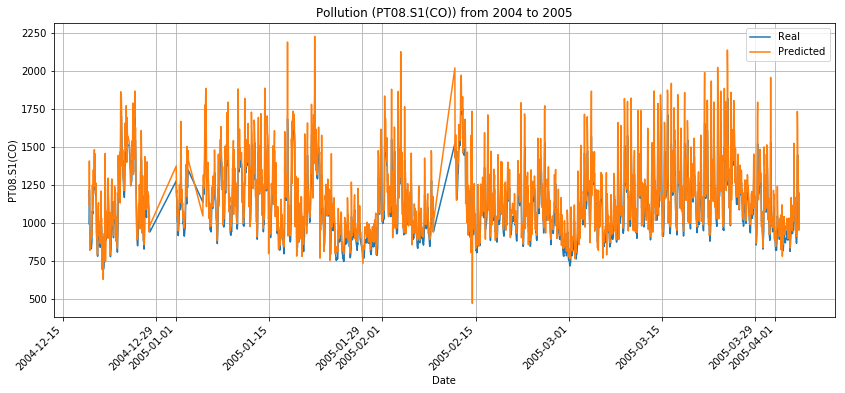

,Real,Predicted
count,2332.000000,2332.000000
mean,1110.438533,1172.967676
std,210.098240,244.435804
min,691.000000,468.034512
25%,947.000000,989.807873
50%,1077.000000,1119.229905
75%,1242.250000,1307.789242
max,1846.000000,2226.751353


In [0]:
predicted_data_norm = linear_regression_model.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(predicted_data_norm)
dates = dataset_no_season['DateTime'][-predicted_data.size:];
predicted_with_season = undoDiffData(dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):],predicted_data.flatten())
original_test_set = dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):].values;
linear_regression_prediction = compareRealWithPredicted(original_test_set,predicted_with_season,dates)
linear_regression_prediction.describe()

In [0]:
rmse = (mean_squared_error(linear_regression_prediction['Real'],linear_regression_prediction['Predicted']))**0.5
r2score = r2_score(linear_regression_prediction['Real'],linear_regression_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics_no_seasonality['Linear Regression']['R2 Score - RFE'] = r2score
result_metrics_no_seasonality['Linear Regression']['RMSE - RFE'] = rmse

RMSE: 103.67
R2: 0.76


#### Random Forest

In [0]:
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train_norm, y_train_norm.values.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

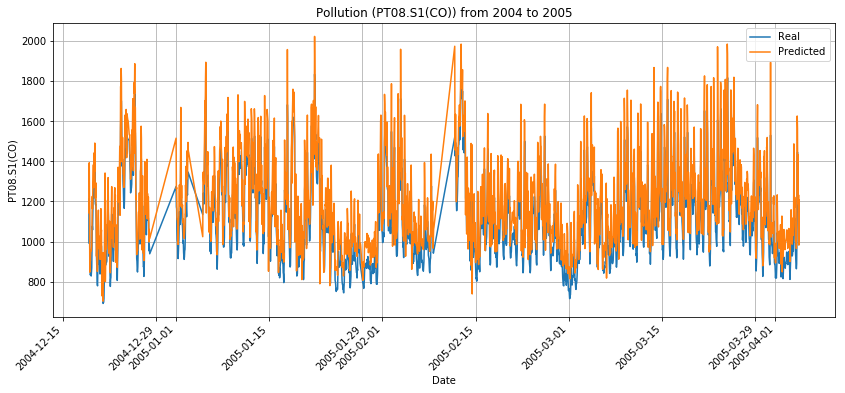

,Real,Predicted
count,2332.000000,2332.000000
mean,1110.438533,1203.297148
std,210.098240,223.000011
min,691.000000,702.478226
25%,947.000000,1034.043713
50%,1077.000000,1156.895506
75%,1242.250000,1335.870606
max,1846.000000,2024.035692


In [0]:
prediction_norm = rf.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(prediction_norm.reshape(-1, 1))
dates = dataset_no_season['DateTime'][-predicted_data.size:];

predicted_with_season = undoDiffData(dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):],predicted_data.flatten())
original_test_set = dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):].values;
random_forest_prediction = compareRealWithPredicted(original_test_set,predicted_with_season,dates)
random_forest_prediction.describe()

In [0]:
rmse = (mean_squared_error(random_forest_prediction['Real'],random_forest_prediction['Predicted']))**0.5
r2score = r2_score(random_forest_prediction['Real'],random_forest_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics_no_seasonality['Random Forest']['R2 Score - RFE'] = r2score
result_metrics_no_seasonality['Random Forest']['RMSE - RFE'] = rmse

RMSE: 111.75
R2: 0.72


#### XGBoost

In [0]:
dtrain = xgb.DMatrix(X_train_norm, y_train_norm)
dtest = xgb.DMatrix(X_test_norm, y_test_norm)
# specify parameters via map, definition are same as c++ version
params = {
    'max_depth':3, 
    'eta':1, 
    'silent':1,
    'objective':'reg:linear',
    'subsample': 0.8,   
    'num_parallel_tree': 10,
    'learning_rate':0.05}

# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 200
bst = xgb.train(params, dtrain, num_round, watchlist, evals_result=evals_result);

[0]	eval-rmse:0.135759	train-rmse:0.079151
[1]	eval-rmse:0.134194	train-rmse:0.075939
[2]	eval-rmse:0.132708	train-rmse:0.072917
[3]	eval-rmse:0.131185	train-rmse:0.070051
[4]	eval-rmse:0.12962	train-rmse:0.067331
[5]	eval-rmse:0.128201	train-rmse:0.064764
[6]	eval-rmse:0.126676	train-rmse:0.062334
[7]	eval-rmse:0.125364	train-rmse:0.060033
[8]	eval-rmse:0.123896	train-rmse:0.057861
[9]	eval-rmse:0.122532	train-rmse:0.055806
[10]	eval-rmse:0.121024	train-rmse:0.053857
[11]	eval-rmse:0.119575	train-rmse:0.052018
[12]	eval-rmse:0.118182	train-rmse:0.050285
[13]	eval-rmse:0.11695	train-rmse:0.048649
[14]	eval-rmse:0.115756	train-rmse:0.047112
[15]	eval-rmse:0.114492	train-rmse:0.045662
[16]	eval-rmse:0.113169	train-rmse:0.044301
[17]	eval-rmse:0.112183	train-rmse:0.043033
[18]	eval-rmse:0.111052	train-rmse:0.041838
[19]	eval-rmse:0.110058	train-rmse:0.04071
[20]	eval-rmse:0.109137	train-rmse:0.039653
[21]	eval-rmse:0.108456	train-rmse:0.038668
[22]	eval-rmse:0.107679	train-rmse:0.037742
[

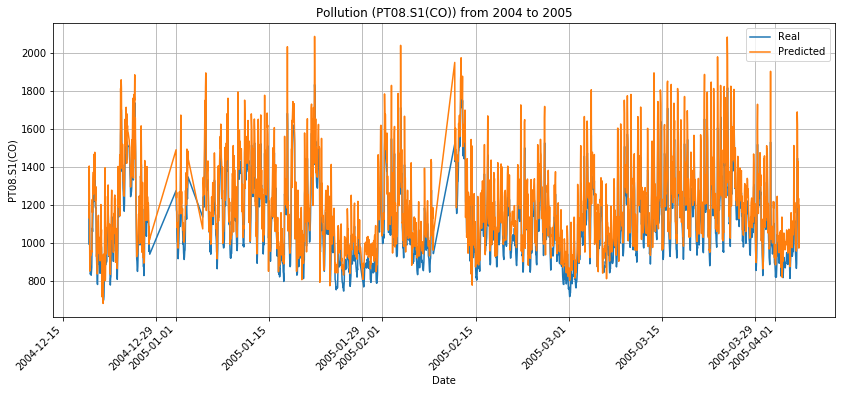

,Real,Predicted
count,2332.000000,2332.000000
mean,1110.438533,1197.490441
std,210.098240,229.998372
min,691.000000,678.768331
25%,947.000000,1023.924119
50%,1077.000000,1147.821575
75%,1242.250000,1330.365793
max,1846.000000,2089.479795


In [0]:
predicted_norm = bst.predict(dtest)
predicted_data = scaler_y_test.inverse_transform(pd.DataFrame(predicted_norm))
dates = dataset_no_season['DateTime'][-predicted_data.size:];

predicted_with_season = undoDiffData(dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):],predicted_data.flatten())
original_test_set = dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):].values;
xgboost_prediction = compareRealWithPredicted(original_test_set,predicted_with_season,dates)
xgboost_prediction.describe()

In [0]:
rmse = (mean_squared_error(xgboost_prediction['Real'],xgboost_prediction['Predicted']))**0.5
r2score = r2_score(xgboost_prediction['Real'],xgboost_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics_no_seasonality['XGBoost']['R2 Score - RFE'] = r2score
result_metrics_no_seasonality['XGBoost']['RMSE - RFE'] = rmse

RMSE: 110.20
R2: 0.72


#### Multi Layer Perceptron Neural Network

In [0]:
mlp = MLPRegressor(hidden_layer_sizes=(X.columns.size,),
                                       activation='relu',
                                       solver='adam',
                                       learning_rate='adaptive',
                                       max_iter=1000,
                                       learning_rate_init=0.01,
                                       alpha=0.01,
                                       validation_fraction=0.2 )
model = mlp.fit(X_train_norm, y_train_norm.values.ravel())

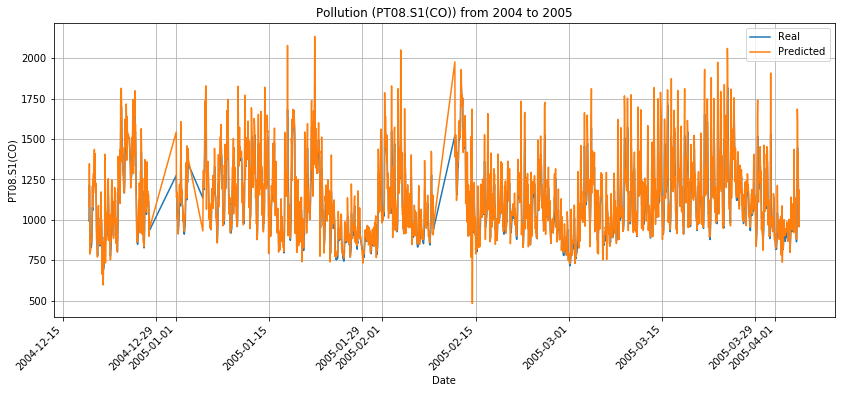

,Real,Predicted
count,2332.000000,2332.000000
mean,1110.438533,1139.669953
std,210.098240,240.675708
min,691.000000,482.064262
25%,947.000000,956.953272
50%,1077.000000,1088.867484
75%,1242.250000,1274.846791
max,1846.000000,2135.785129


In [0]:
prediction_norm = model.predict(X_test_norm)
predicted_data = scaler_y_test.inverse_transform(pd.DataFrame(prediction_norm))
dates = dataset_no_season['DateTime'][-predicted_data.size:];

predicted_with_season = undoDiffData(dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):],predicted_data.flatten())
original_test_set = dataset_interpolate['PT08.S1(CO)'][-len(predicted_data.flatten()):].values;
mlp_prediction = compareRealWithPredicted(original_test_set,predicted_with_season,dates)
mlp_prediction.describe()

In [0]:
rmse = (mean_squared_error(mlp_prediction['Real'],mlp_prediction['Predicted']))**0.5
r2score = r2_score(mlp_prediction['Real'],mlp_prediction['Predicted'])
print("RMSE: %.2f" %rmse)
print('R2: %.2f'%r2score)
result_metrics_no_seasonality['MLP']['R2 Score - RFE'] = r2score
result_metrics_no_seasonality['MLP']['RMSE - RFE'] = rmse

RMSE: 82.95
R2: 0.84


### Discussing Results

Results from all datasets and situations:

In [0]:
result_metrics

,Linear Regression,Random Forest,XGBoost,MLP
R2 Score - Linear Corr,0.862507,0.916481,0.907271,0.876806
R2 Score - RFE,0.893592,0.853787,0.878517,0.892769
RMSE - Linear Corr,72.4235,56.446,59.4766,68.5542
RMSE - RFE,63.7128,74.6847,68.0765,63.9586


In [0]:
result_metrics_no_seasonality

,Linear Regression,Random Forest,XGBoost,MLP
R2 Score - Linear Corr,0.720038,0.639952,0.711393,0.648184
R2 Score - RFE,0.756411,0.716964,0.724783,0.844045
RMSE - Linear Corr,111.142,126.04,112.845,124.591
RMSE - RFE,103.671,111.751,110.196,82.9524


Analysing the data with seasonality, we have the Random Forest, using the features selected by the linear correlations, having the highest score and also making a faithful prediction of data, that is, it has a good understanding of the pollution data and also its peak points and valley points.

Analysing the data without seasonality, we can see that the MLP, with the features selected by the RFE method, has the best metrics. 

Although the overall metrics for the prediction with the seasonality looks better (higher R2 Score and lower RMSE), when we look at the prediction plots for the dataset without seasonality, it is noticiable that all models reached the peak values for this situation. In fact, some of them predicted higher values than the real data, and that could be useful depending on the use of these models.

Overall, the models proposed for the data with seasonality seemed to outperform the models to predict data without seasonality.